# 💬 **Customer Sentiment Analysis**

**Analytics Portfolio - Project 2**

**Author: Nadia Rozman**

## **Project Objective**

The objective of this project is to analyze customer review data in order to:
- Identify overall sentiment patterns
- Extract frequently occurring positive and negative themes
- Compare traditional NLP feature representations (BoW vs TF-IDF)
- Build an Artificial Neural Network (ANN) model to classify customer sentiment
- Provide actionable insights to support service quality improvement

### **Library Imports & Environment Setup**

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

In [34]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

# Create directory for visual outputs
os.makedirs("images", exist_ok=True)

### **Data Loading & Initial Exploration**

In [35]:
# Load customer reviews dataset
df = pd.read_excel("hotel_reviews.xlsx")

# Retain relevant columns
df = df[["reviews.text", "reviews.rating"]]

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (10000, 2)


,reviews.text,reviews.rating
0,Our experience at Rancho Valencia was absolute...,5.0
1,Amazing place. Everyone was extremely warm and...,5.0
2,We booked a 3 night stay at Rancho Valencia to...,5.0
3,Currently in bed writing this for the past hr ...,2.0
4,I live in Md and the Aloft is my Home away fro...,5.0


In [37]:
# Remove missing review text
df = df.dropna(subset=["reviews.text"])
print(f"Dataset after cleaning: {df.shape[0]} reviews")

Dataset after cleaning: 9999 reviews


### **Rating Distribution Overview**

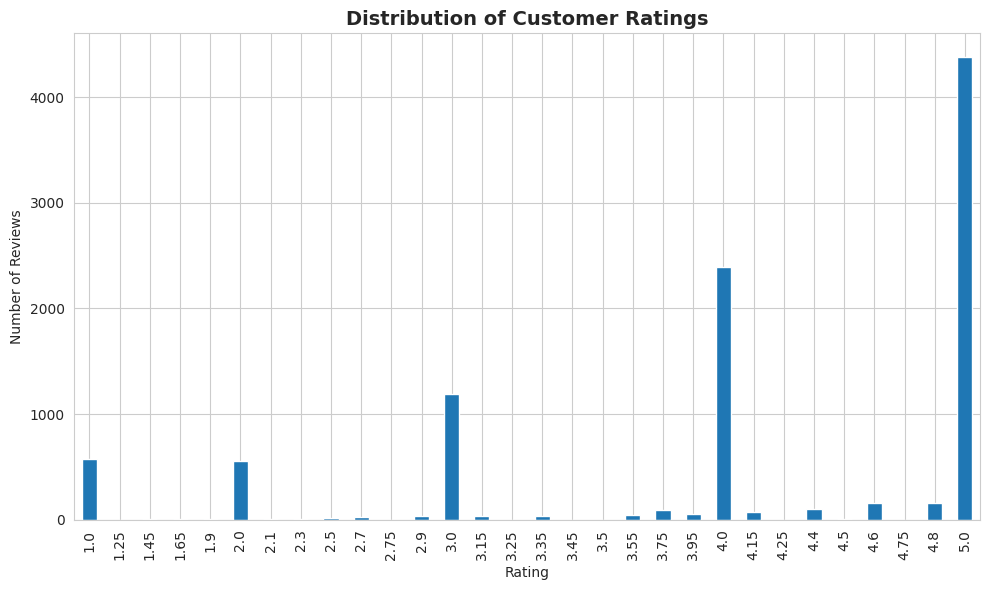

In [38]:
# Rating distribution
df["reviews.rating"].value_counts().sort_index()

# Visualize rating distribution
fig, ax = plt.subplots(figsize=(10, 6))
df["reviews.rating"].value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Distribution of Customer Ratings", fontsize=14, fontweight="bold")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Reviews")
plt.tight_layout()
plt.savefig("images/1_ratings_overview.png", dpi=300)
plt.show()

### **Text Preprocessing Pipeline**

**1. Text Cleaning**

In [39]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("vader_lexicon", quiet=True)

print("NLTK resources downloaded successfully")

NLTK resources downloaded successfully


In [40]:
# Function to clean raw text
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r"\d+", "", text)       # Remove numbers
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation
    return text

# Apply basic cleaning
df["clean_text"] = df["reviews.text"].apply(basic_clean)

print("Sample cleaned text:")
print(df[['reviews.text', 'clean_text']].head())

Sample cleaned text:
                                        reviews.text  \
0  Our experience at Rancho Valencia was absolute...   
1  Amazing place. Everyone was extremely warm and...   
2  We booked a 3 night stay at Rancho Valencia to...   
3  Currently in bed writing this for the past hr ...   
4  I live in Md and the Aloft is my Home away fro...   

                                          clean_text  
0  our experience at rancho valencia was absolute...  
1  amazing place everyone was extremely warm and ...  
2  we booked a  night stay at rancho valencia to ...  
3  currently in bed writing this for the past hr ...  
4  i live in md and the aloft is my home away fro...  


**2. Tokenization, Stopword Removal & Lemmatization**

In [41]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

def tokenize_remove_stopwords(text):
    tokens = word_tokenize(text)
    return [w for w in tokens if w.isalpha() and w not in stop_words]

df["tokens"] = df["clean_text"].apply(tokenize_remove_stopwords)

print(f"Sample tokens: {df['tokens'].iloc[0][:10]}")

Sample tokens: ['experience', 'rancho', 'valencia', 'absolutely', 'perfect', 'beginning', 'end', 'felt', 'special', 'happy']


In [42]:
# Initialize lemmatizer (using lemmatization only as requested)
lemmatizer = WordNetLemmatizer()

df["processed_tokens"] = df["tokens"].apply(
    lambda tokens: [lemmatizer.lemmatize(w) for w in tokens]
)

df["processed_text"] = df["processed_tokens"].apply(lambda x: " ".join(x))

print("Sample processed text:")
print(df['processed_text'].iloc[0])

Sample processed text:
experience rancho valencia absolutely perfect beginning end felt special happy stayed would come back heart beat


### **Feature Engineering: BoW vs TF-IDF**

In [43]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create corpus from processed text
corpus = df['processed_text'].tolist()

**1. Bag of Words (BoW)**

In [44]:
# Create Bag-of-Words vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(corpus)

**2. TF-IDF (Term Frequency-Inverse Document Frequency)**

In [45]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

### **Comparison: BoW vs TF-IDF**

**Bag of Words (BoW):**
- Counts raw frequency of words
- Treats all words equally
- Simple and interpretable
- May overweight common words

**TF-IDF:**
- Weighs words by importance (rare words get higher weight)
- Reduces impact of very common words
- Better for capturing document uniqueness
- More suitable for classification tasks

**For this analysis:** We'll use BoW for keyword frequency analysis and TF-IDF for machine learning classification.


### **Sentiment Analysis with VADER**

In [46]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute compound sentiment score
df["sentiment_score"] = df["reviews.text"].apply(
    lambda x: sia.polarity_scores(str(x))["compound"]
)

In [47]:
# Function to convert compound score to sentiment label
def sentiment_label(score):
    if score < -0.05:
        return "Negative"
    elif score > 0.05:
        return "Positive"
    else:
        return "Neutral"

df["sentiment"] = df["sentiment_score"].apply(sentiment_label)

# Display sentiment distribution
print("VADER Sentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

VADER Sentiment Distribution:
sentiment
Positive    8313
Negative    1372
Neutral      314
Name: count, dtype: int64


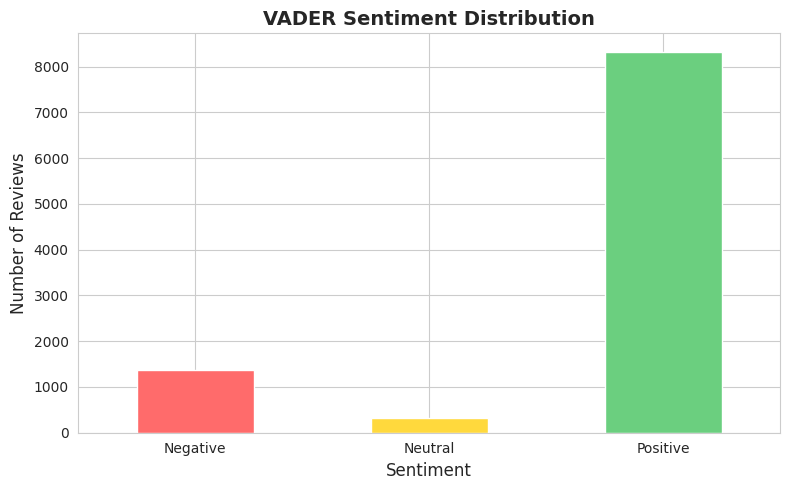

In [48]:
# Visualize sentiment distribution
sentiment_counts_ordered = df['sentiment'].value_counts().reindex(['Negative', 'Neutral', 'Positive'])

fig, ax = plt.subplots(figsize=(8, 5))
sentiment_counts_ordered.plot(kind='bar', color=['#ff6b6b', '#ffd93d', '#6bcf7f'], ax=ax)
ax.set_title('VADER Sentiment Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig('images/2_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### **Keyword Analysis**

In [49]:
from collections import Counter

# Separate reviews by sentiment
positive_reviews = df[df['sentiment'] == 'Positive']['processed_tokens']
negative_reviews = df[df['sentiment'] == 'Negative']['processed_tokens']

# Flatten token lists
positive_tokens = [token for tokens in positive_reviews for token in tokens]
negative_tokens = [token for tokens in negative_reviews for token in tokens]

# Count word frequencies
positive_counter = Counter(positive_tokens)
negative_counter = Counter(negative_tokens)

# Extract top 10 words
top_positive_words = dict(positive_counter.most_common(10))
top_negative_words = dict(negative_counter.most_common(10))

print("Top 10 Positive Keywords:")
for word, count in top_positive_words.items():
    print(f"  {word}: {count}")

print("\nTop 10 Negative Keywords:")
for word, count in top_negative_words.items():
    print(f"  {word}: {count}")

Top 10 Positive Keywords:
  room: 7245
  hotel: 6208
  staff: 3725
  stay: 3410
  great: 3398
  clean: 3140
  good: 3089
  breakfast: 2685
  nice: 2672
  friendly: 2021

Top 10 Negative Keywords:
  room: 1366
  hotel: 807
  bad: 425
  good: 366
  stay: 327
  night: 314
  one: 268
  staff: 257
  would: 247
  desk: 245


**Word Cloud Visualization**

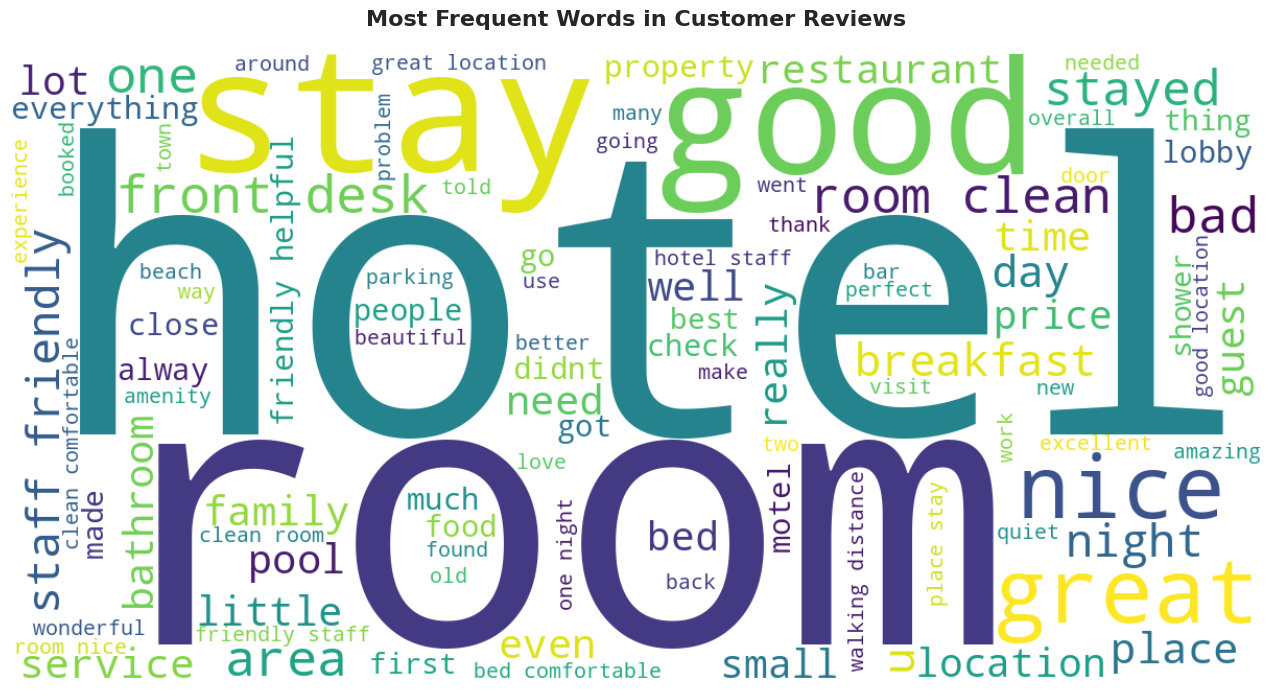

In [52]:
from wordcloud import WordCloud

# Combine all processed text
all_text = ' '.join(df['processed_text'])

# Generate word cloud
wordcloud = WordCloud(width=1200, height=600,
                      background_color='white',
                      colormap='viridis',
                      max_words=100).generate(all_text)

# Display word cloud
fig, ax = plt.subplots(figsize=(15, 7))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Most Frequent Words in Customer Reviews', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/3_reviews_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

### **Machine Learning Classification**

**1. Create Labels from Ratings**

In [53]:
# Convert ratings to sentiment classes
def rating_to_class(rating):
    """Convert numerical rating to sentiment class"""
    if rating < 2.5:
        return 0  # Negative
    elif rating <= 3.5:
        return 1  # Neutral
    else:
        return 2  # Positive

df['rating_class'] = df['reviews.rating'].apply(rating_to_class)

# Display class distribution
class_dist = df['rating_class'].value_counts().sort_index()
class_dist.index = ['Negative', 'Neutral', 'Positive']

print("Rating-Based Sentiment Classes:")
print(class_dist)

Rating-Based Sentiment Classes:
Negative    1176
Neutral     1345
Positive    7478
Name: count, dtype: int64


**2. Train-Test Split**

In [54]:
from sklearn.model_selection import train_test_split

# Define features and target
X_bow_array = X_bow.toarray()
X_tfidf_array = X_tfidf.toarray()
y = df['rating_class']

# Split data (using TF-IDF for better classification performance)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_array, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Feature dimension: {X_train.shape[1]}")

Training set size: 7999
Test set size: 2000
Feature dimension: 5000


**3. Model Training: MLP Classifier**

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced data
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(2.8335104498760186), np.int64(1): np.float64(2.478004956629492), np.int64(2): np.float64(0.4457260670901594)}


In [56]:
# Initialize and train MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=300,
    activation='relu',
    solver='adam',
    random_state=42,
    verbose=False
)

print("Training MLP classifier...")
mlp.fit(X_train, y_train)
print("Training complete!")

Training MLP classifier...
Training complete!


In [57]:
# Make predictions
y_pred = mlp.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2%}")

Test Accuracy: 77.10%


In [58]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Negative', 'Neutral', 'Positive'],
                          digits=2))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.48      0.51       235
     Neutral       0.35      0.36      0.35       269
    Positive       0.88      0.89      0.88      1496

    accuracy                           0.77      2000
   macro avg       0.59      0.58      0.58      2000
weighted avg       0.77      0.77      0.77      2000



**4. Model Evaluation**

In [59]:
# Predicted vs Actual Distribution
labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
y_test_labels = pd.Series(y_test).map(labels_map)
y_pred_labels = pd.Series(y_pred).map(labels_map)

actual_counts = y_test_labels.value_counts().reindex(['Negative', 'Neutral', 'Positive'])
predicted_counts = y_pred_labels.value_counts().reindex(['Negative', 'Neutral', 'Positive'])

df_comparison = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
})

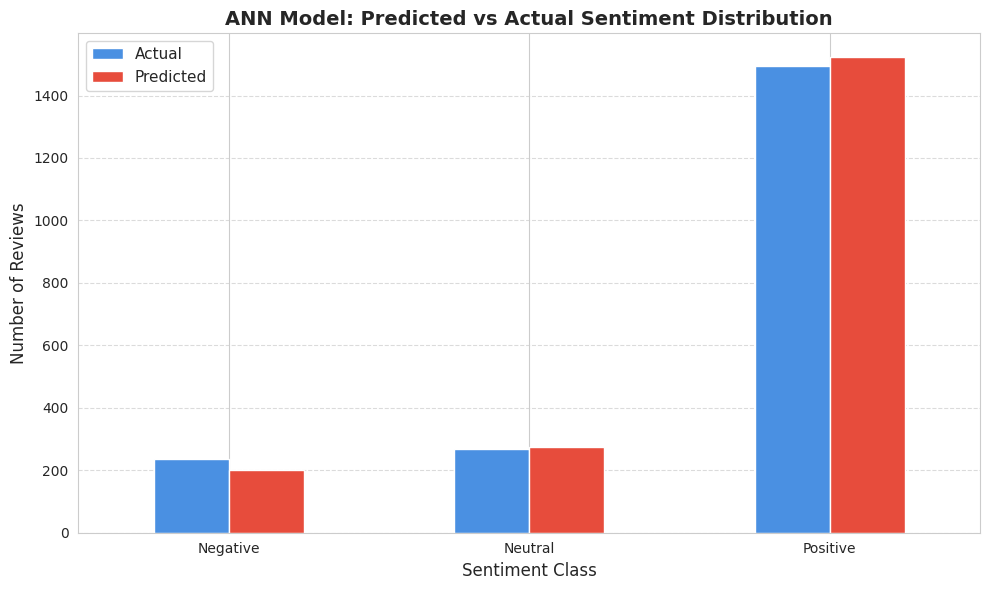

In [60]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
df_comparison.plot(kind='bar', ax=ax, color=['#4a90e2', '#e74c3c'])
ax.set_title('ANN Model: Predicted vs Actual Sentiment Distribution',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Class', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='', fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('images/4_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

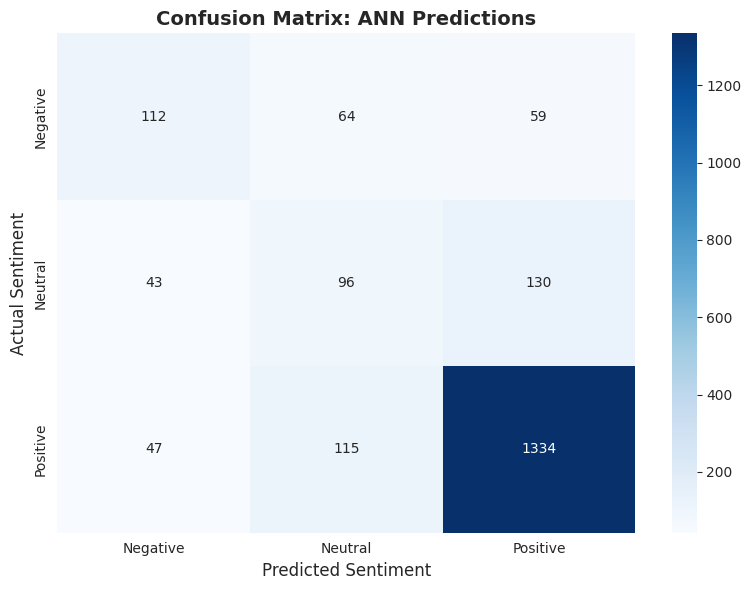

In [61]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_title('Confusion Matrix: ANN Predictions', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted Sentiment', fontsize=12)
ax.set_ylabel('Actual Sentiment', fontsize=12)
plt.tight_layout()
plt.savefig('images/5_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()